# My Image Classifier Attempt after fast.ai Lesson 1

Note: did this on a google cloud VM. Ran into problems so won't use this preemptive instance again.

## Goals:
- Build a classifier
- Scrape, load images
- Use and explore fastai library


## Steps
- Clone repo that allows me to scrape images off the internet
- Scrape images
- Sort into image-net type of directory structure
    - images/
        - models/
            - class1
            - class2
            - class3
        - train/
            - class1
            - class2
            - class3
- load images
- explore data
- create learner
- identify most-missed classes
- improve learning rate


##### Note that labels are the class1, class2, class3 folders containing images, not embedded in filenames, csv, json, etc

### Scrape Images

I used the ultralytics google-images-download repo, which actually built a bing image scraper on top of someone else's google image scraper. Had to go to ultralytics repo because I couldn't solve some issues with scraping from google images.

This required that I command-line installed google chrome and google driver. I just googled wget commands for command-line install of both

Linux commands for getting the google-images-download repo:

In [ ]:
git clone https://github.com/ultralytics/google-images-download
cd google-images-download
pip install -U -r requirements.txt

#### Scrape images (100-150)

- Required chromedriver for scraping over 100 images.
- Example linux commands from within the google-images-download directory on my VM

In [ ]:
python3 bing_scraper.py --search 'navy warships' --limit 100 --download --chromedriver /usr/bin/chromedriver
python3 bing_scraper.py --search 'army tanks' --limit 100 --download --chromedriver /usr/bin/chromedriver
python3 bing_scraper.py --search 'air force jets' --limit 100 --download --chromedriver /usr/bin/chromedriver
python3 bing_scraper.py --search 'air force tankers' --limit 150 --download --chromedriver /usr/bin/chromedriver
python3 bing_scraper.py --search 'commercial airliners' --limit 150 --download --chromedriver /usr/bin/chromedriver
python3 bing_scraper.py --search 'army bradleys' --limit 150 --download --chromedriver /usr/bin/chromedriver
python3 bing_scraper.py --search 'russian tanks' --limit 150 --download --chromedriver /usr/bin/chromedriver
python3 bing_scraper.py --search 'chinese warships' --limit 150 --download --chromedriver /usr/bin/chromedriver
python3 bing_scraper.py --search 'army stryker' --limit 150 --download --chromedriver /usr/bin/chromedriver
python3 bing_scraper.py --search 'army m113 personnel carrier' --limit 150 --download --chromedriver /usr/bin/chromedriver


### Train/Test Split

Bing scraper put all images in the /train directory under a directory of the search term (e.g. ~/google-images-download/images/train/army_tanks) . 

I moved ~20% of them to the corresponding /valid directory (e.g. ~/google-images-download/images/valid/army_tanks)

#### File Structure Looked Like This:
- ~/google-images-download/images
    - /train
        - army_tanks
        - navy_warships
        - ...
    - /valid
        - army_tanks
        - navy_warships
        - ...



##### Note, this file structure is similar to imagenet and easily accessed by fastai library so that's why it's used.

#### Cleaning

I didn't know which images would work, so attempted to train the model multiple times as I got errors for certain images. I'd then remove those images manually. Probably not the smartest way to do it, but eventually effective

# Now to the actual python!

Imports

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.metrics import error_rate

batch size = 64...for 64 images at a time?

In [ ]:
bs = 64

path to directory containing the /train and /valid directories of images labeled by their own sub directories

In [ ]:
path = "/home/jupyter/google-images-download/images"

#honestly no idea what setting transforms does
tfms = get_transforms(do_flip=False)





In [ ]:
data = ImageDataBunch.from_folder(path, size=224, no_check=True).normalize(imagenet_stats)

Initially I made the size way too small (24) because I was using a line that had used MNIST handwriting. Bad move. Everything was so pixelated.


Now we'll see if we've got the right data. Labels on top, photos below.

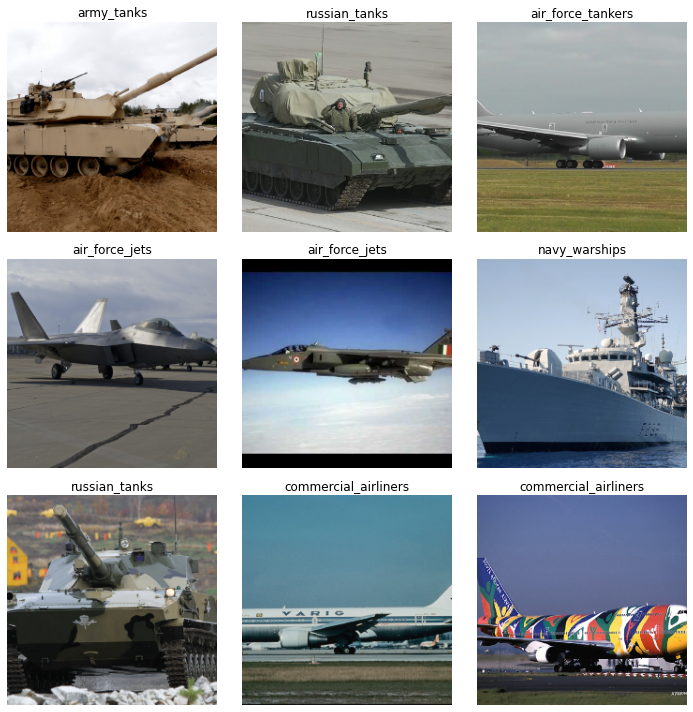

In [61]:
data.show_batch(rows = 3, figsize = (10,10))

check if the data actually includes all 10 classes:

In [62]:
print(data.classes)

['air_force_jets', 'air_force_tankers', 'army_bradleys', 'army_m113_personnel_carrier', 'army_stryker', 'army_tanks', 'chinese_warships', 'commercial_airliners', 'navy_warships', 'russian_tanks']


In [ ]:
len(data.classes), data.c

### Training a model: I use resnet34

In [66]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [67]:
learn.model;
learn.fit_one_cycle(4) #won't have the right learning rate

In [72]:
learn.save('stage-1') #save the model

### Results

In [73]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

#### Show the most-mistaken images

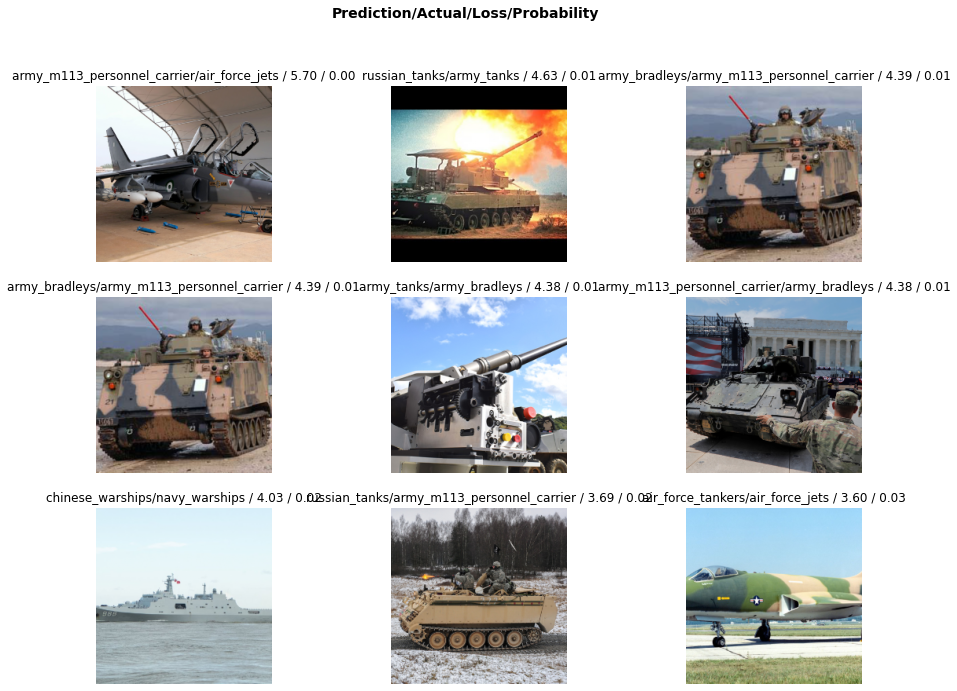

In [74]:
interp.plot_top_losses(9, figsize=(15,11))

#### Now in a confusion matrix

Looks like:
- Army bradleys are mistaken for tanks
- Air force jets mistaken for air force tankers (potentially because of improper image labeling? I didn't check each image versus its label because I didn't know how to do that in command line.
- Russian and American tanks mistaken for one another
- Navy warships and chinese warships mistaken for one another
- Army personnel carriers mistaken for bradleys


Overall, we classified 80% correctly, which isn't terrible for things that look pretty similar, but far from perfect.

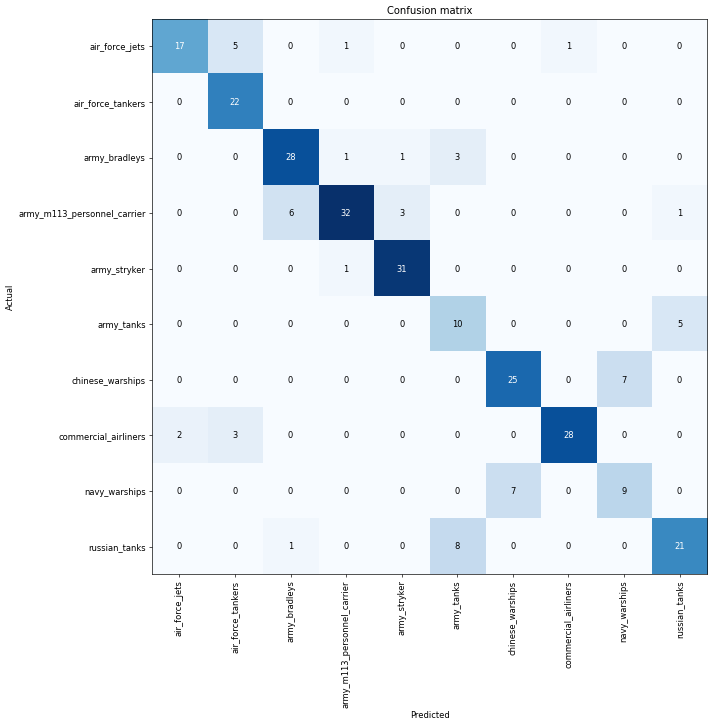

In [75]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [76]:
interp.most_confused(min_val=2)

[('russian_tanks', 'army_tanks', 8),
 ('chinese_warships', 'navy_warships', 7),
 ('navy_warships', 'chinese_warships', 7),
 ('army_m113_personnel_carrier', 'army_bradleys', 6),
 ('air_force_jets', 'air_force_tankers', 5),
 ('army_tanks', 'russian_tanks', 5),
 ('army_bradleys', 'army_tanks', 3),
 ('army_m113_personnel_carrier', 'army_stryker', 3),
 ('commercial_airliners', 'air_force_tankers', 3),
 ('commercial_airliners', 'air_force_jets', 2)]

### Improve the learning rate

In [50]:
learn.unfreeze() #unfreezes model so you can train again

In [51]:
learn.fit_one_cycle(1) #let's train again to find the learning rate that works best

epoch,train_loss,valid_loss,error_rate,time
0,0.623281,1.130715,0.293907,00:22


In [52]:
learn.lr_find() #finds the learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


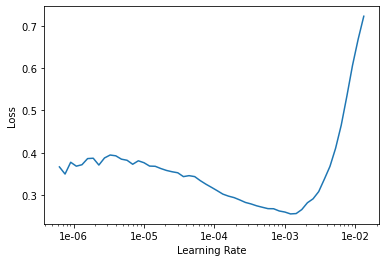

In [53]:
learn.recorder.plot() #plots it. Want to slice lr to a range that's low not shooting up.

#in this case (1e-5, 1e-3) works well




In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-5, 1e-3))

In [ ]:
learn.save('stage-2') #save the model